```
This notebook sets up and runs a test case for analyzing Kelvin waves
Copyright (C) 2018 - 2022 SINTEF Digital
Copyright (C) 2018 - 2022 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 26b98e82e8d4e1ca2369cf735af8c7d3af460403 on branch reduced_gravity


# Oslofjord
Testing of Nils projected files

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [3]:
from gpuocean.utils import IPythonMagic, Common, NetCDFInitialization, WindStress, OceanographicUtilities

from gpuocean.SWEsimulators import CDKLM16

In [4]:
%cuda_context_handler barotropic_gpu_ctx

In [5]:
%cuda_context_handler baroclinic_gpu_ctx

In [6]:
%cuda_context_handler drifter_gpu_ctx

Path to the test file

In [7]:
source_url = "/sintef/data/OsloFjord/test_polstere_1h_0007.nc"

## Inspecting file structure and content

In [8]:
from netCDF4 import Dataset
nc = Dataset(source_url)

In [9]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:     (ocean_time: 720, s_rho: 42, s_w: 43, eta_rho: 741, xi_rho: 397, xi_u: 396, eta_v: 740)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2014-06-30T13:00:00 ... 2014-07-3...
  * s_rho       (s_rho) float64 -0.9881 -0.9643 -0.9405 ... -0.03571 -0.0119
  * s_w         (s_w) float64 -1.0 -0.9762 -0.9524 ... -0.04762 -0.02381 0.0
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/15)
    projection  int32 ...
    Cs_r        (s_rho) float64 ...
    Cs_w        (s_w) float64 ...
    h           (eta_rho, xi_rho) float32 ...
    mask_rho    (eta_rho, xi_rho) float32 ...
    angle       (eta_rho, xi_rho) float32 ...
    ...          ...
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    u           (ocean_time, s_rho, eta_rho, xi_u) float32 ...
    v           (ocean_time, s_rho, eta_v, xi_rho) float32 ...
    lat_rho     (eta_rho, xi_rho) float32 ...
    lon_rho     (eta_rho, xi_rho) float32 ...

Animation utils

In [10]:
import animation_utils

## Generating GPUOcean Simulation from Input

General parameters

In [11]:
dimY, dimX = ds.h.data.shape
x0, x1, y0, y1 = 5, dimX-5, 175, dimY-5

Simulation span: 6h!

In [12]:
t_start = 5*24
t_stop =  t_start + 6

T = (t_stop-t_start)*3600  #Input
timestep_indices = [list(np.arange(t_start, t_stop+1))]

Generating wind fields

In [13]:
from gpuocean.utils import WindStress

def generate_wind_field(wind_angle_deg, t_start_index, T):
    """Generating WindStress object with spatially constant, hourly varying wind 
    according to the standard shape in Oslofjord (see Oslofjord-ArtificialParameters.ipynb)
    
    wind_angle_deg - angle of wind field towards north in degree!
    t_start_index  - index for the time when generated wind field is supposed to start
    T              - time span for which the wind field is generated in seconds
    """

    wind_angle = np.deg2rad(wind_angle_deg)

    # Reference wind speed for 0 - 24h 
    wind_u_ref = np.zeros(24)
    wind_u_ref[:10] = -0.5*(np.sin(2*np.pi*(np.arange(0,10)-2.5)/10)+1)
    wind_u_ref[10:] = 5*(np.sin(2*np.pi*(np.arange(10,24)+0.5)/14)+1)

    # Wind fields for 0 - 24h
    wind_u = list(np.cos(wind_angle)*wind_u_ref[:,np.newaxis][:,np.newaxis].astype(np.float32))
    wind_v = list(np.sin(wind_angle)*wind_u_ref[:,np.newaxis][:,np.newaxis].astype(np.float32))

    # Shifting that reference hours align with t_0
    shift = datetime.datetime.utcfromtimestamp(nc["ocean_time"][t_start_index]).hour
    for shift_hour in range(shift):
        wind_u.append(wind_u.pop(0))
        wind_v.append(wind_v.pop(0))

    # Repeat for several days if necessary
    wind_u = wind_u * int(np.ceil((T/3600+1)/24))
    wind_v = wind_v * int(np.ceil((T/3600+1)/24))

    # Cut relevant time span
    wind_u = wind_u[0:int(T/3600+1)]
    wind_v = wind_v[0:int(T/3600 +1)]

    # Construct time array in simulator time (starting with 0)
    ts = np.arange(T+1, step=3600)

    # Init WindStress object
    wind = WindStress.WindStress(t=ts, wind_u=wind_v, wind_v=wind_u)
    wind.compute_wind_stress_from_wind()

    return wind 

### Initial conditions

In [14]:
ref_barotropic_data_args, ref_baroclinic_data_args = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, 1024.0, timestep_indices=timestep_indices, norkyst_data=False, land_value=0.0, download_data=False)

KeyboardInterrupt: 

#### Barotropic Simulations

In [ ]:
ref_barotropic_data_args["wind"] = generate_wind_field(45.0, t_start, T)

In [ ]:
ref_barotropic_sim = CDKLM16.CDKLM16(barotropic_gpu_ctx, **NetCDFInitialization.removeMetadata(ref_barotropic_data_args), dt=0.0, write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


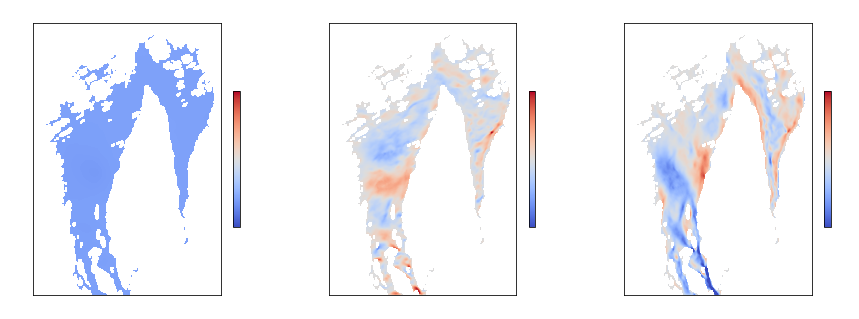

In [ ]:
bt_eta, bt_hu, bt_hv = ref_barotropic_sim.download()

fig, axs = plt.subplots(1,3, figsize=(15,5))

im = axs[0].imshow(bt_eta, vmin=-0.5, vmax=0.5, cmap="coolwarm")
axs[0].set_title("eta")
plt.colorbar(im, ax=axs[0], shrink=0.5)

im = axs[1].imshow(bt_hu, vmin=-5, vmax=5, cmap="coolwarm")
axs[1].set_title("hu")
plt.colorbar(im, ax=axs[1], shrink=0.5)

im = axs[2].imshow(bt_hv, vmin=-5, vmax=5, cmap="coolwarm")
axs[2].set_title("hv")
plt.colorbar(im, ax=axs[2], shrink=0.5)

In [ ]:
subt = 3600
for runt in range(int(T/subt)):
    ref_barotropic_sim.step(subt)


In [19]:
# with plt.rc_context({'lines.color':'black', 
#                         'text.color':'black', 
#                         'axes.labelcolor':'black', 
#                         'xtick.color':'black',
#                         'ytick.color':'black'}):
#     anim = animation_utils.ncAnimation(barotropic_sim.sim_writer.output_file_name, "gpuocean", comment="GPUOcean")
#     anim.save("anims/barotropic_test.mp4")

#### Baroclinic Simulations

In [20]:
ref_baroclinic_data_args["wind"] = generate_wind_field(45.0, t_start, T)
ref_baroclinic_data_args["wind_stress_factor"] = 0.3

In [21]:
ref_baroclinic_sim = CDKLM16.CDKLM16(baroclinic_gpu_ctx, **NetCDFInitialization.removeMetadata(ref_baroclinic_data_args), dt=0.0, write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


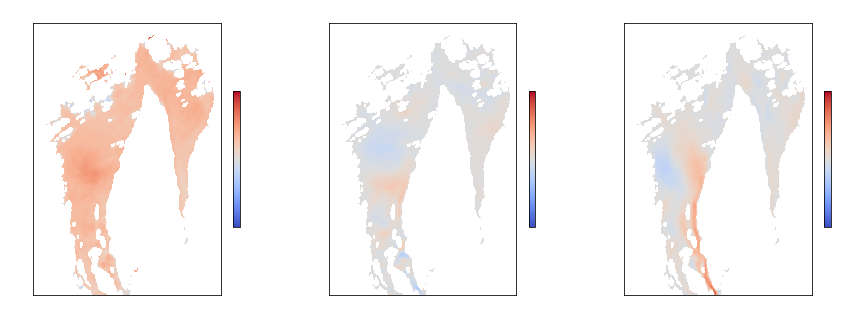

In [22]:
bc_eta, bc_hu, bc_hv = ref_baroclinic_sim.download()

fig, axs = plt.subplots(1,3, figsize=(15,5))

im = axs[0].imshow(-bc_eta, vmin=-15, vmax=0, cmap="coolwarm")
axs[0].set_title("MLD")
plt.colorbar(im, ax=axs[0], shrink=0.5)

im = axs[1].imshow(bc_hu, vmin=-5, vmax=5, cmap="coolwarm")
axs[1].set_title("hu")
plt.colorbar(im, ax=axs[1], shrink=0.5)

im = axs[2].imshow(bc_hv, vmin=-5, vmax=5, cmap="coolwarm")
axs[2].set_title("hv")
plt.colorbar(im, ax=axs[2], shrink=0.5)

In [23]:
subt = 3600
for runt in range(int(T/subt)):
    ref_baroclinic_sim.step(subt)

In [24]:
# with plt.rc_context({'lines.color':'black', 
#                         'text.color':'black', 
#                         'axes.labelcolor':'black', 
#                         'xtick.color':'black',
#                         'ytick.color':'black'}):
#     anim = animation_utils.ncAnimation(ref_baroclinic_sim.sim_writer.output_file_name, "gpuocean-reduced_grav", comment="GPUOcean")
#     anim.save("anims/baroclinic_test.mp4")

#### Combined deterministic simulation with drifters

Just for reference

In [25]:
from gpuocean.SWEsimulators import CombinedCDKLM16

ref_barotropic_sim = CDKLM16.CDKLM16(barotropic_gpu_ctx, **NetCDFInitialization.removeMetadata(ref_barotropic_data_args), dt=0.0, write_netcdf=False)
ref_baroclinic_sim = CDKLM16.CDKLM16(baroclinic_gpu_ctx, **NetCDFInitialization.removeMetadata(ref_baroclinic_data_args), dt=0.0, write_netcdf=False)

ref_sims = CombinedCDKLM16.CombinedCDKLM16(barotropic_sim=ref_barotropic_sim, baroclinic_sim=ref_baroclinic_sim)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Closing file /home/florianb/havvarsel/reduced-gravity-ocean-model/notebooks/Oslofjord/netcdf_2023_03_22/CDKLM16_2023_03_22-20_16_12.nc ...
Closing file /home/florianb/havvarsel/reduced-gravity-ocean-model/notebooks/Oslofjord/netcdf_2023_03_22/CDKLM16_2023_03_22-20_16_40.nc ...


In [26]:
from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [27]:
observation_type = dautils.ObservationType.UnderlyingFlow 
    
observation_args = {'observation_type': observation_type,
                'nx': ref_sims.nx, 'ny': ref_sims.ny,
                'domain_size_x': ref_sims.nx*ref_sims.dx,
                'domain_size_y': ref_sims.ny*ref_sims.dy,
                'land_mask': ref_sims.getLandMask()
                }

trajectories = Observation.Observation(**observation_args)

In [17]:
initx = [ 6000, 8000, 5000,  12000, 15000, 4000]
inity = [12000, 2500, 7500, 22000, 16000, 15000]

num_drifters = len(initx)

drifters = GPUDrifterCollection.GPUDrifterCollection(drifter_gpu_ctx, num_drifters,
                                                    boundaryConditions = ref_sims.boundary_conditions,
                                                    domain_size_x = trajectories.domain_size_x,
                                                    domain_size_y = trajectories.domain_size_y,
                                                    gpu_stream = ref_sims.gpu_stream,
                                                    wind=generate_wind_field(45.0, t_start, T),
                                                    wind_drift_factor=0.02/2 # halfend since drift kernel called twice
                                                    )

drifter_pos_init = np.array([initx, inity]).T
drifters.setDrifterPositions(drifter_pos_init)

Exception caught: Resetting to CUDA context drifter_gpu_ctx
Traceback (most recent call last):
  File "/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2253873/1511427416.py", line 6, in <module>
    drifters = GPUDrifterCollection.GPUDrifterCollection(drifter_gpu_ctx, num_drifters,
NameError: name 'GPUDrifterCollection' is not defined


NameError: name 'GPUDrifterCollection' is not defined

In [29]:
ref_sims.attachDrifters(drifters)
trajectories.add_observation_from_sim(ref_sims)

In [30]:
ref_sims.combinedStep(T, trajectory_dt=60, trajectories=trajectories)

(21600.0, 21600.0)

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  # Remove the CWD from sys.path while we load stuff.


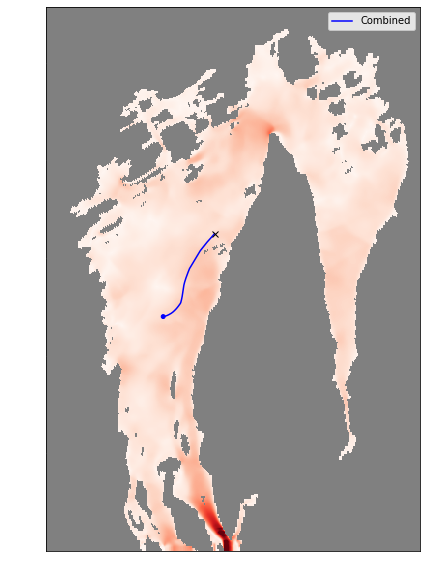

In [31]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

combined_eta, combined_u, combined_v = ref_sims.download() 
uv_field = np.sqrt(combined_u**2 + combined_v**2)


domain_extent = [0, ref_sims.nx*ref_sims.dx, 0, ref_sims.ny*ref_sims.dy]

velo_cmap = copy.deepcopy(plt.cm.Reds)
velo_cmap.set_bad("grey", alpha = 1.0)

ax.imshow(uv_field, interpolation="none", origin='lower', 
                cmap=velo_cmap, 
                vmin=0.0, vmax=0.5, 
                extent=domain_extent)

drifter_path = trajectories.get_drifter_path(0, 0, ref_sims.t, in_km = False)[0]

start_pos = drifter_path[0,:]
circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                100, color = 'blue',
                                                fill=True, zorder=10)
ax.add_patch(circ_start)

ax.plot(drifter_path[:,0], drifter_path[:,1], color="blue", ls="-", zorder=5, label="Combined")
end_pos = drifter_path[-1,:]
ax.plot(end_pos[0], end_pos[1], 'x', color='k', zorder=11)


ax.legend(labelcolor="black")


In [40]:
lats = nc["lat_rho"][:,0]
lons = nc["lon_rho"][0,:]

initlats = [None] * len(initx)
initlons = [None] * len(inity)

for d in range(len(initlats)):
    xindex0 = np.floor( x0 - 0.5 + initx[d]/50.0 ).astype(int)
    xindex1 = xindex0 + 1
    interpolator = 0.5 + initx[d]/50 - np.floor(0.5 + initx[d]/50) 

    initlons[d] = (1-interpolator) * lons[xindex0] + interpolator * lons[xindex1]


    yindex0 = np.floor( y0 - 0.5 + inity[d]/50 ).astype(int)
    yindex1 = yindex0 + 1
    interpolator = 0.5 + inity[d]/50 - np.floor(0.5+inity[d]/50) 

    initlats[d] = (1-interpolator) * lats[yindex0] + interpolator * lats[yindex1]

In [42]:
initlats, initlons

([59.78610610961914,
  59.700775146484375,
  59.74568176269531,
  59.8759651184082,
  59.822044372558594,
  59.81306076049805],
 [10.55042552947998,
  10.58590030670166,
  10.53268814086914,
  10.656847953796387,
  10.710057258605957,
  10.5149507522583])

In [19]:
lats[0]

59.599995

## Cross Pert Drifters

The test scenario should be
- X barotropic simulations (different `wind`)
- Y wind drift factors (connected to barotropic sims, since wind response of baroclinic model is already well covered)
- Z baroclinic simulations (2 different `wind`, with 2 different `wind_stress_factors` and 3 different `g`)

In [32]:
import pandas as pd 

In [33]:
wind_angles_degs = np.arange(0, 91, 45)
wind_samples = [None]*len(wind_angles_degs)

for i in range(len(wind_angles_degs)):
    wind_samples[i] = generate_wind_field(wind_angles_degs[i], t_start, T)

In [34]:
baroclinic_wind_angles_degs = np.arange(0, 91, 45)
baroclinic_wind_samples = [None]*len(baroclinic_wind_angles_degs)

for i in range(len(baroclinic_wind_angles_degs)):
    baroclinic_wind_samples[i] = generate_wind_field(baroclinic_wind_angles_degs[i], t_start, T)

In [35]:
barotropic_wind_angles_degs = np.arange(0, 91, 45)
barotropic_wind_samples = [None]*len(barotropic_wind_angles_degs)

for i in range(len(barotropic_wind_angles_degs)):
    barotropic_wind_samples[i] = generate_wind_field(barotropic_wind_angles_degs[i], t_start, T)

Collect perturbations

In [36]:
# Barotropic data args by starting from earlier timesteps and doing a sufficient spin-up
barotropic_data_args = []

spinup_t = 24

spinup_barotropic_data_args = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1, timestep_indices=[np.arange(t_start-spinup_t, t_start+1)], norkyst_data=False, land_value=0.0, download_data=False)
spinup_barotropic_data_args.pop("wind")

for wind_direction in barotropic_wind_angles_degs:
    print(wind_direction)
    wind = WindStress.WindStress(t=[0], wind_u=[np.array([[np.cos(np.deg2rad(wind_direction))*10]]).astype(np.float32)], wind_v=[np.array([[np.sin(np.deg2rad(wind_direction))*10]]).astype(np.float32)])
    spinup_barotropic_sim = CDKLM16.CDKLM16(barotropic_gpu_ctx, **NetCDFInitialization.removeMetadata(spinup_barotropic_data_args), dt=0.0, wind=wind)
    spinup_barotropic_sim.step(spinup_t*3600)
    eta, hu, hv = spinup_barotropic_sim.download()

    spunup_barotropic_data_args = copy.copy(ref_barotropic_data_args)
    spunup_barotropic_data_args["eta0"] = eta
    spunup_barotropic_data_args["hu0"] = hu
    spunup_barotropic_data_args["hv0"] = hv
    spunup_barotropic_data_args["wind"] = generate_wind_field(wind_direction, t_start, T)
    barotropic_data_args.append(spunup_barotropic_data_args)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


0


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


45


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


90


In [37]:
# Mixed layer depth (MLD) 
# Can be explored coupled or decoupled with the reduced gravity constant
mld_dens_samples = np.arange(1022.5, 1024.6, 1.0)
mld_samples_data_args = [None]*len(mld_dens_samples)

for i in range(len(mld_dens_samples)):
    _, mld_samples_data_args[i] = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, 
                                                                                    mld_dens_samples[i], timestep_indices=timestep_indices, norkyst_data=False, land_value=0.0, download_data=False)
    print(mld_samples_data_args[i]["g"])


0.030270605610380003
0.02590019048200965
0.020022437452273542


In [38]:
wind_stress_samples = np.arange(0.1, 0.51, 0.2)

In [39]:
friction_samples = np.arange(0, 0.0051, 0.0025)

In [20]:
windage_samples = np.arange(0.0, 0.051, 0.025)

Generate all contextes

In [41]:
bc_gpu_ctxs = []
for i in range(len(baroclinic_wind_samples)):
    bc_gpu_ctxs.append( Common.CUDAContext() )

bt_gpu_ctxs = []
for i in range(len(barotropic_wind_samples)):
    bt_gpu_ctxs.append( Common.CUDAContext() )

#### Creating simulators

In [42]:
barotropic_sims = []

for i in range(len(barotropic_data_args)):
    barotropic_sims.append( CDKLM16.CDKLM16(bt_gpu_ctxs[i], **NetCDFInitialization.removeMetadata(barotropic_data_args[i]),  dt=0.0))

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [43]:
baroclinic_sims = []
bc_table = pd.DataFrame(columns=["baroclinic_id", "wind_angle_id", "wind_stress_factor_id", "friction_id", "mld_id"]).set_index("baroclinic_id")

for i_w in range(len(baroclinic_wind_samples)):
    for i_ws in range(len(wind_stress_samples)):
        for i_f in range(len(friction_samples)):
            for i_mld in range(len(mld_samples_data_args)):
                baroclinic_data_args = copy.copy(mld_samples_data_args[i_mld])
                baroclinic_data_args["wind"] = baroclinic_wind_samples[i_w]
                baroclinic_data_args["wind_stress_factor"] = wind_stress_samples[i_ws]
                baroclinic_data_args["r"] = friction_samples[i_f]

                baroclinic_sims.append( CDKLM16.CDKLM16(bc_gpu_ctxs[i_w], **NetCDFInitialization.removeMetadata(baroclinic_data_args),  dt=0.0))
                
                bc_table.loc[len(bc_table.index)] = [i_w, i_ws, i_f, i_mld]

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

In [44]:
bc_table

,wind_angle_id,wind_stress_factor_id,friction_id,mld_id
baroclinic_id,,,,
0,0,0,0,0
1,0,0,0,1
2,0,0,0,2
3,0,0,1,0
4,0,0,1,1
...,...,...,...,...
76,2,2,1,1
77,2,2,1,2
78,2,2,2,0


#### Cross Product Table 

In [45]:
ref_table = pd.DataFrame(columns=["drifter_id", "barotropic_id", "baroclinic_id", "windage_id"]).set_index("drifter_id")

In [46]:
for bt in range(len(barotropic_sims)):
    for bc in range(len(baroclinic_sims)):
        for windage in range(len(windage_samples)):
            ref_table.loc[len(ref_table.index)] = [bt, bc, windage]

In [47]:
ref_table

,barotropic_id,baroclinic_id,windage_id
drifter_id,,,
0,0,0,0
1,0,0,1
2,0,0,2
3,0,1,0
4,0,1,1
...,...,...,...
724,2,79,1
725,2,79,2
726,2,80,0


Collecting drifter and observation objects

In [48]:
from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [49]:
observation_type = dautils.ObservationType.UnderlyingFlow 
    
observation_args = {'observation_type': observation_type,
                'nx': ref_barotropic_sim.nx, 'ny': ref_barotropic_sim.ny,
                'domain_size_x': ref_barotropic_sim.nx*ref_barotropic_sim.dx,
                'domain_size_y': ref_barotropic_sim.ny*ref_barotropic_sim.dy,
                'land_mask': ref_barotropic_sim.getLandMask()
                }

trajectories = Observation.Observation(**observation_args)


In [50]:
initx = [ 6000, 8000, 5000,  12000, 15000, 4000]
inity = [12000, 3000, 7500, 22000, 16000, 15000]

num_drifters = len(initx)

In [51]:
crossprod_trajectories = []
for cp in range(len(ref_table)):
    crossprod_trajectories.append(copy.deepcopy(trajectories))

In [52]:
crossprod_drifters = []
for cp in range(len(ref_table)): 
    drifters = GPUDrifterCollection.GPUDrifterCollection(bt_gpu_ctxs[ref_table.iloc[cp].barotropic_id], # OBS: This is used for wind drift! 
                                                    num_drifters,
                                                    boundaryConditions = ref_barotropic_sim.boundary_conditions,
                                                    domain_size_x = trajectories.domain_size_x,
                                                    domain_size_y = trajectories.domain_size_y,
                                                    gpu_stream = barotropic_sims[ref_table.iloc[cp].barotropic_id].gpu_stream, # OBS!
                                                    wind = barotropic_wind_samples[ref_table.iloc[cp].barotropic_id],
                                                    wind_drift_factor = windage_samples[ref_table.iloc[cp].windage_id]/2 # drift is called twice per step, but we only want one wind contribution
                                                    )           

    drifter_pos_init = np.array([initx, inity]).T
    drifters.setDrifterPositions(drifter_pos_init)
    crossprod_drifters.append(drifters)

Attach CPdrifters

In [53]:
from itertools import compress

In [54]:
for bt in range(len(barotropic_sims)):
    barotropic_sims[bt].attachCrossProductDrifters( 
        list(compress(crossprod_drifters, ref_table["barotropic_id"] == bt)), 
        [baroclinic_sims[i] for i in list(ref_table[ref_table["barotropic_id"] == bt].baroclinic_id)] )

Let's fan out the drifters!

In [55]:
bc_dt = min([bc.dt for bc in baroclinic_sims])

In [56]:
for bc in baroclinic_sims:
    bc.step(bc_dt)

In [57]:
for bt in barotropic_sims:
    bt.step(bc_dt)

In [58]:
for d in range(len(crossprod_drifters)):
    crossprod_trajectories[d].add_observation_from_drifters(crossprod_drifters[d], bt.t)

In [59]:
while bt.t < T:
    print(bt.t)

    bc_dt = min([bc.dt for bc in baroclinic_sims])
    if bt.t % 3600 != 0:
        bc_dt = min(bc_dt, np.ceil(bt.t/3600)*3600 - bt.t)

    for bc in baroclinic_sims:
        bc.step(bc_dt)

    for bt in barotropic_sims:
        bt.step(bc_dt)

    for d in range(len(crossprod_drifters)):
        crossprod_trajectories[d].add_observation_from_drifters(crossprod_drifters[d], bt.t)

10.201848602294923
20.403697204589847
30.60554580688477
40.80739440917969
51.00924301147462
61.21109161376954
71.41294021606447
81.61478881835939
91.8166374206543
102.01848602294922
112.22033462524413
122.42218322753905
132.62403182983397
142.82588043212888
153.0277290344238
163.22957763671872
173.43142623901363
183.63327484130855
193.83512344360346
204.03697204589838
214.2388206481933
224.4406692504882
234.64251785278313
244.84436645507805
255.04621505737296
265.2480636596679
275.4499122619628
285.65176086425777
295.8536094665527
306.05545806884766
316.2573066711426
326.45915527343755
336.6610038757325
346.86285247802743
357.0647010803224
367.2665496826173
377.46839828491227
387.6702468872072
397.87209548950216
408.0739440917971
418.27579269409205
428.477641296387
438.67948989868194
448.8813385009769
459.0831871032718
469.28503570556677
479.4868843078617
489.68873291015666
499.8905815124516
510.09243011474655
520.2942787170415
530.4961273193364
540.6979759216314
550.8998245239263
561.

In [4]:
def plot_cp_trajectories(crossprod_trajectories, drifter_id):
    with plt.rc_context({'lines.color':'black', 
                            'text.color':'black', 
                            'axes.labelcolor':'black', 
                            'xtick.color':'black',
                            'ytick.color':'black'}):
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        ax.tick_params(axis='both', which='major', labelsize=28)
        domain_extent = [0, ref_sims.nx*ref_sims.dx/1000, 0, ref_sims.ny*ref_sims.dy/1000]

        bg_cmap = copy.deepcopy(plt.cm.Blues)
        bg_cmap.set_bad("grey", alpha = 1.0)

        ax.imshow(barotropic_sims[0].download()[0] > -10, interpolation="none", origin='lower', 
                        cmap=bg_cmap,  
                        extent=domain_extent)

        path = crossprod_trajectories[0].get_drifter_path(drifter_id, 0, T, in_km = True)[0]
        start_pos = path[0,:]
        circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                0.01, color = 'black', fill=True, zorder=10)
        ax.add_patch(circ_start)

        for path in [t.get_drifter_path(drifter_id, 0, T, in_km = True)[0] for t in crossprod_trajectories]:
            
            ax.plot(path[:,0], path[:,1], color="C0", ls="-", zorder=5, alpha=0.1)
            
            end_pos = path[-1,:]
            ax.scatter(end_pos[0], end_pos[1], marker='x', color='black', s=100, linewidths=2)

        plt.tight_layout()

        plt.savefig("figs/CPdrift"+str(drifter_id)+".pdf", bbox_inches="tight")

In [ ]:
for drifter_id in range(num_drifters):
    plot_cp_trajectories(crossprod_trajectories, drifter_id)

In [ ]:
os.makedirs("pickles", exist_ok=True)
for cp in range(len(crossprod_trajectories)):
    crossprod_trajectories[cp].to_pickle("pickles/cp_trajectory"+str(cp))


In [ ]:
STOP

## Post-Processing

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [2]:
source_url = "/sintef/data/OsloFjord/test_polstere_1h_0007.nc"

In [3]:
from netCDF4 import Dataset
nc = Dataset(source_url)

In [4]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:     (ocean_time: 720, s_rho: 42, s_w: 43, eta_rho: 741, xi_rho: 397, xi_u: 396, eta_v: 740)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2014-06-30T13:00:00 ... 2014-07-3...
  * s_rho       (s_rho) float64 -0.9881 -0.9643 -0.9405 ... -0.03571 -0.0119
  * s_w         (s_w) float64 -1.0 -0.9762 -0.9524 ... -0.04762 -0.02381 0.0
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/15)
    projection  int32 ...
    Cs_r        (s_rho) float64 ...
    Cs_w        (s_w) float64 ...
    h           (eta_rho, xi_rho) float32 ...
    mask_rho    (eta_rho, xi_rho) float32 ...
    angle       (eta_rho, xi_rho) float32 ...
    ...          ...
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    u           (ocean_time, s_rho, eta_rho, xi_u) float32 ...
    v           (ocean_time, s_rho, eta_v, xi_rho) float32 ...
    lat_rho     (eta_rho, xi_rho) float32 ...
    lon_rho     (eta_rho, xi_rho) float32 ...

In [5]:
dimY, dimX = ds.h.data.shape
x0, x1, y0, y1 = 5, dimX-5, 175, dimY-5

In [6]:
from gpuocean.utils import Observation

In [7]:
timestamp = "2023-03-19T14_43_55"

trajectories = []

for f in os.listdir('pickles/'+timestamp):
    obs= Observation.Observation()
    obs.read_pickle('pickles/'+timestamp+'/'+ f )
    trajectories.append( obs )

In [8]:
import pickle
with open("fjordos_opendrift_trajectories_protocol4.pickle", "rb") as f:
    opendrift_results = pickle.load(f)

In [68]:
lats = nc["lat_rho"][y0:y1,x0:x1]
lons = nc["lon_rho"][y0:y1,x0:x1]

In [101]:
initx = [ 6000, 8000, 5000,  12000, 15000, 4000]
inity = [12000, 3000, 7500, 22000, 16000, 15000]

In [111]:
def xy2latlon(x,y, dx=50.0, dy=50.0):
    local_index_x = x/dx + 0.5
    local_index_y = y/dy + 0.5

    def _interp(field, local_index_x, local_index_y):
        local_index_x_lower = int(local_index_x)
        local_index_x_upper = int(local_index_x)+1

        local_index_y_lower = int(local_index_y)
        local_index_y_upper = int(local_index_y)+1

        val00 = (1 - (local_index_x - local_index_x_lower))*(1 - (local_index_y - local_index_y_lower)) * field[local_index_y_lower, local_index_x_lower]
        val01 = (1 - (local_index_x - local_index_x_lower))*(local_index_y - local_index_y_lower) * field[local_index_y_upper, local_index_x_lower]
        val10 = (local_index_x - local_index_x_lower)*(1 - (local_index_y - local_index_y_lower)) * field[local_index_y_lower, local_index_x_upper]
        val11 = (local_index_x - local_index_x_lower)*(local_index_y - local_index_y_lower) * field[local_index_y_upper, local_index_x_upper]
        return val00 + val01 + val10 + val11 
    
    return (_interp(lats, local_index_x, local_index_y), _interp(lons, local_index_x, local_index_y))

In [112]:
[xy2latlon(x, y) for x,y in list(zip(initx,inity))]

[(59.78606414794922, 10.554881572723389),
 (59.70504665374756, 10.58893370628357),
 (59.74572563171387, 10.536277055740356),
 (59.875346183776855, 10.664061546325684),
 (59.821105003356934, 10.716439247131348),
 (59.81318473815918, 10.519662380218506)]

In [113]:
lat, lon = xy2latlon(initx[0], inity[0])

In [164]:
def latlon2xy(lat, lon, dx=50.0, dy=50.0):
    penalty = (lats - lat)**2 + (lons - lon)**2
    idx_y, idx_x = np.argwhere( penalty==penalty.min() )[0]

    if lats[idx_y, idx_x] > lat:
        idx_y_lower = idx_y-1
        idx_y_upper = idx_y 
    else:
        idx_y_lower = idx_y 
        idx_y_upper = idx_y+1

    if lons[idx_y, idx_x] > lon:
        idx_x_lower = idx_x-1
        idx_x_upper = idx_x 
    else:
        idx_x_lower = idx_x  
        idx_x_upper = idx_x+1

    y = idx_y_lower + (lat - lats[idx_y_lower, idx_x])/(lats[idx_y_upper, idx_x] - lats[idx_y_lower, idx_x])
    x = idx_x_lower + (lon - lons[idx_y, idx_x_lower])/(lons[idx_y, idx_x_upper] - lons[idx_y, idx_x_lower])

    return (y-0.5)*dy, (x-0.5)*dx

In [165]:
latlon2xy(lat, lon)

(12000.213675213676, 6000.240384615385)

In [149]:
lats[243,15], lons[240,121]

(59.78761, 10.555324)

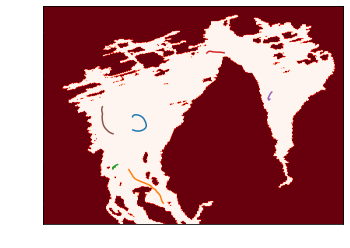

In [23]:
fig, ax = plt.subplots(1,1, )
domain_extent = [nc["lon_rho"][y0:y1,x0:x1].min(), nc["lon_rho"][y0:y1,x0:x1].max(), nc["lat_rho"][y0:y1,x0:x1].min(), nc["lat_rho"][y0:y1,x0:x1].max()]
ax.imshow(1-nc["mask_rho"][y0:y1,x0:x1], extent=domain_extent, cmap="Reds")
for i in range(len(opendrift_results["lon"])):
    ax.plot(opendrift_results["lon"][i], opendrift_results["lat"][i])

In [36]:
[ trajectories[0].get_drifter_path(d, 0, 100, in_km = True)[0] for d in range(6)]

[array([[ 6.00206982, 12.00011621],
        [ 6.01241895, 12.00087109]]),
 array([[8.0004834 , 3.00062256],
        [8.00290039, 3.00373975]]),
 array([[4.99978662, 7.50013525],
        [4.99872168, 7.50084961]]),
 array([[12.00015527, 22.00077539],
        [12.0010459 , 22.0050332 ]]),
 array([[15.00061816, 16.00007715],
        [15.00370996, 16.00046777]]),
 array([[ 3.99902344, 14.99957422],
        [ 3.99421729, 14.99744531]])]

In [43]:
trajectories[0].obs_df

,time,drifter_positions,drifter_obs_errors,buoy_observations,buoy_positions,buoy_obs_errors
0,10,"[[6002.07, 12000.116], [8000.4834, 3000.6226],...",None,None,None,None
1,61,"[[6012.419, 12000.871], [8002.9004, 3003.7397]...",None,None,None,None
2,122,"[[6024.838, 12001.95], [8005.801, 3007.5925], ...",None,None,None,None
3,184,"[[6037.257, 12003.169], [8008.7227, 3011.6443]...",None,None,None,None
4,245,"[[6049.676, 12004.563], [8011.74, 3015.9597], ...",None,None,None,None
...,...,...,...,...,...,...
348,21346,"[[8121.3154, 15276.639], [8090.0195, 4260.153]...",None,None,None,None
349,21407,"[[8126.1904, 15286.621], [8089.9053, 4260.27],...",None,None,None,None
350,21469,"[[8131.064, 15296.605], [8089.791, 4260.387], ...",None,None,None,None
351,21530,"[[8135.917, 15306.59], [8089.677, 4260.5044], ...",None,None,None,None


In [47]:
ts = [ (otime - opendrift_results["time"][0]).seconds for otime in opendrift_results["time"]]

In [57]:
np.array(X).shape

(37,)

In [53]:
X = [(x-x0)*50.0 for x in opendrift_results["x"][0]] #* 50.0

In [45]:
def plot_cp_trajectories(crossprod_trajectories, drifter_id):
    with plt.rc_context({'lines.color':'black', 
                            'text.color':'black', 
                            'axes.labelcolor':'black', 
                            'xtick.color':'black',
                            'ytick.color':'black'}):
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        ax.tick_params(axis='both', which='major', labelsize=28)

        domain_extent = [0, (x1-x0)*50.0/1000, 0, (y1-y0)*50.0/1000]

        bg_cmap = copy.deepcopy(plt.cm.Blues)
        bg_cmap.set_bad("grey", alpha = 1.0)

        ax.imshow(np.ma.array(nc["mask_rho"][y0:y1, x0:x1], mask=(1-nc["mask_rho"][y0:y1, x0:x1])), interpolation="none", origin='lower', 
                        cmap=bg_cmap,  
                        extent=domain_extent)

        path = crossprod_trajectories[0].get_drifter_path(drifter_id, 0, crossprod_trajectories[0].obs_df.iloc[-1].time, in_km = True)[0]
        start_pos = path[0,:]
        circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                0.01, color = 'black', fill=True, zorder=10)
        ax.add_patch(circ_start)

        for path in [t.get_drifter_path(drifter_id, 0, crossprod_trajectories[0].obs_df.iloc[-1].time, in_km = True)[0] for t in crossprod_trajectories]:
            
            ax.plot(path[:,0], path[:,1], color="C0", ls="-", zorder=5, alpha=0.05)
            
            end_pos = path[-1,:]
            ax.scatter(end_pos[0], end_pos[1], marker='x', color='black', s=2, linewidths=1, alpha=0.5, zorder=6)



        ax.plot(((np.array(opendrift_results["x"][0] ) - x0)*50.0)/1000, ((np.array(opendrift_results["y"][0] ) - y0)*50.0)/1000, c="red")


        plt.tight_layout()
        plt.savefig("figs/"+timestamp+"/CPdrift"+str(drifter_id)+".pdf", bbox_inches="tight")

In [46]:
len(trajectories)

1701

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  del sys.path[0]


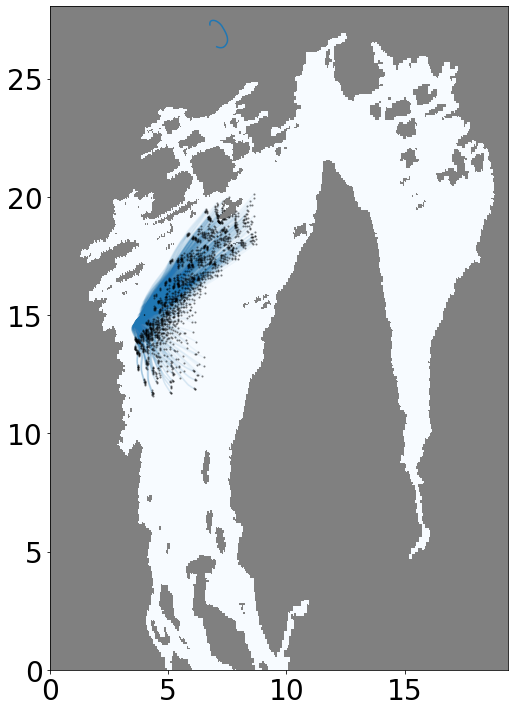

In [47]:
plot_cp_trajectories(trajectories, 5)

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  del sys.path[0]
/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  del sys.path[0]
/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: You are modifying the state of a globally register

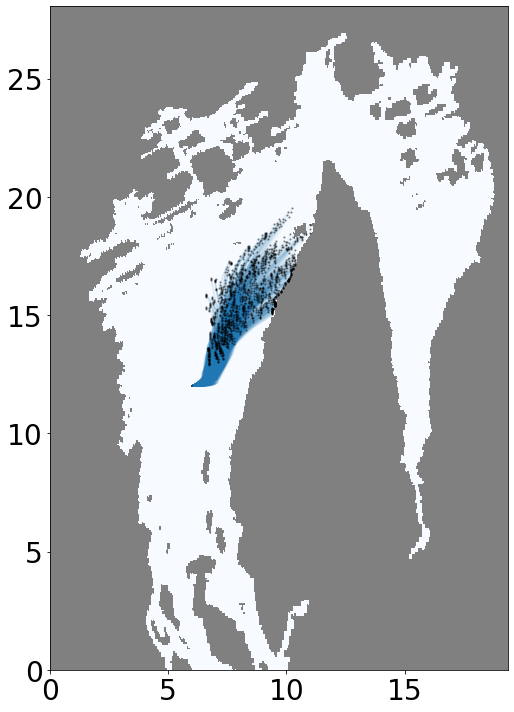

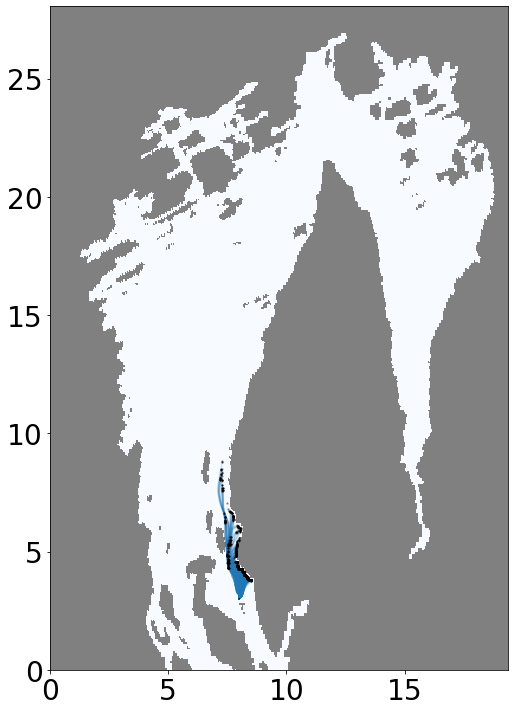

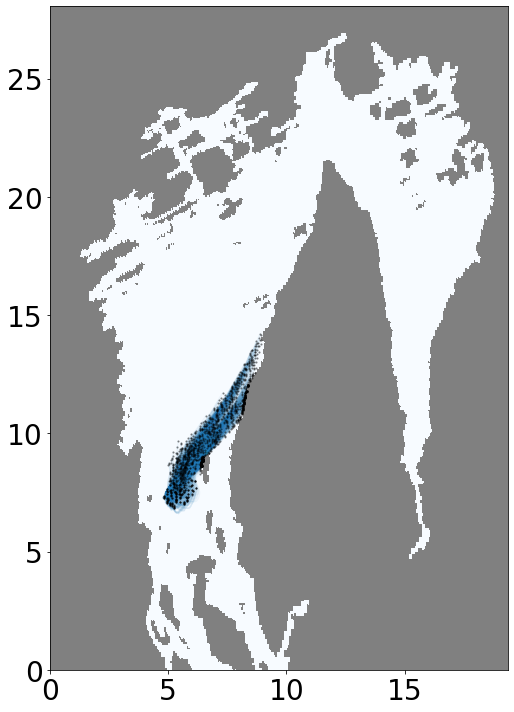

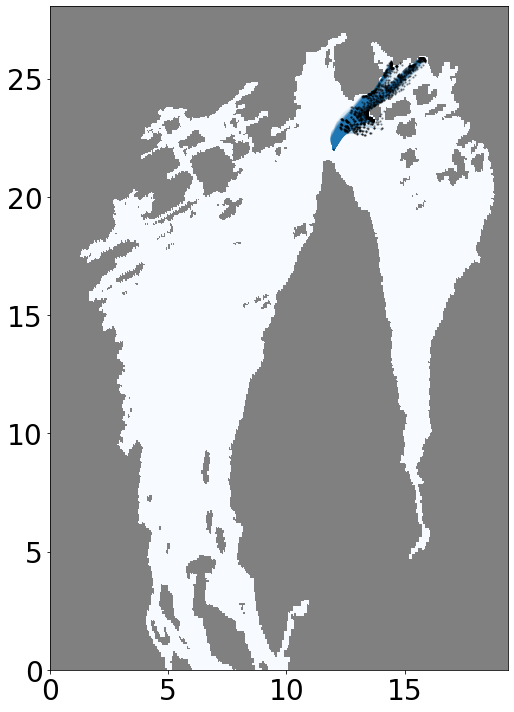

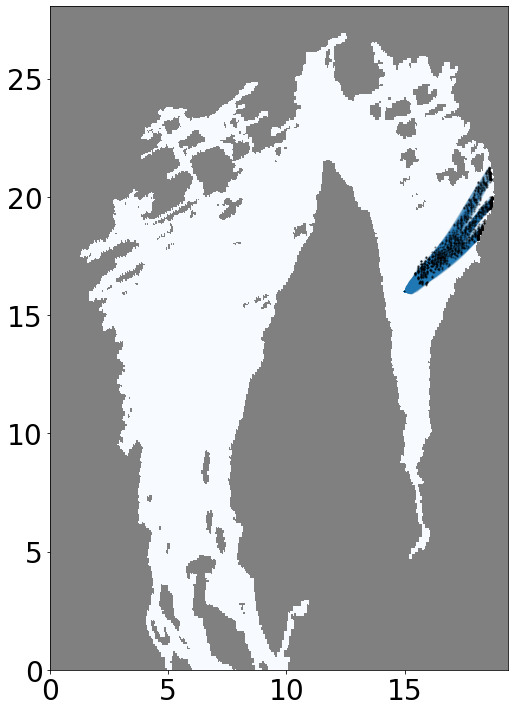

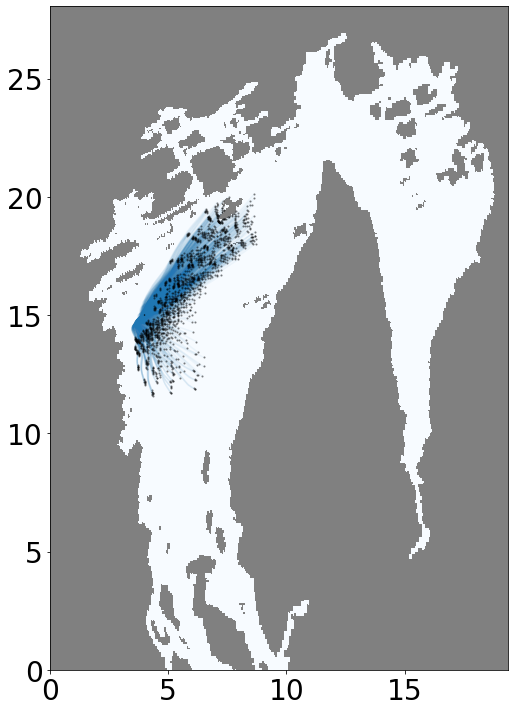

In [11]:
numDrifters = len(trajectories[0].obs_df.iloc[0].drifter_positions)
for d in range(numDrifters):
    plot_cp_trajectories(trajectories, d)

In [12]:
def plot_cp_kde(trajectories, drifter_id):

    # Space and time 
    nx = (x1-x0)
    ny = (y1-y0)

    dx = 50.0
    dy = 50.0

    T = trajectories[0].obs_df.iloc[-1].time

    ## Get last postions
    numTrajectories = len(trajectories)

    last_positions = np.zeros((numTrajectories,2))
    for d in range(numTrajectories):
        last_positions[d] = trajectories[d].get_drifter_path(drifter_id, 0, T)[-1][-1]

    # Axes
    x = np.arange(nx)*dx
    y = np.arange(ny)*dy
    x/=1000
    y/=1000
    xx, yy = np.meshgrid(x,y)
    ccs = np.vstack([xx.ravel(), yy.ravel()])

    ## Kernel density estimation 
    clp = (last_positions-np.average(last_positions,axis=0)).T
    clp[0][clp[0] > (x[-1]/2)] = clp[0][clp[0] > (x[-1]/2)] - x[-1]
    clp[0][clp[0] < (-x[-1]/2)] = clp[0][clp[0] < (-x[-1]/2)] + x[-1]
    clp[1][clp[1] > (y[-1]/2)] = clp[1][clp[1] > (y[-1]/2)] - y[-1]
    clp[1][clp[1] < (-y[-1]/2)] = clp[1][clp[1] < (-y[-1]/2)] + y[-1]

    raw_cov = np.cov(clp)

    bw = 100**(-1./(2+4)) #* 0.5 #for whtatever reason scipy.stats.gaussian_kde is roughly half of that

    cov = raw_cov * bw
    covinv = np.linalg.inv(cov)

    f = np.zeros((ny,nx))
    for e in range(numTrajectories):
        d = (ccs.T-last_positions[e]).T
        d[0][d[0] > (x[-1]/2)] = d[0][d[0] > (x[-1]/2)] - x[-1]
        d[0][d[0] < (-x[-1]/2)] = d[0][d[0] < (-x[-1]/2)] + x[-1]
        d[1][d[1] > (y[-1]/2)] = d[1][d[1] > (y[-1]/2)] - y[-1]
        d[1][d[1] < (-y[-1]/2)] = d[1][d[1] < (-y[-1]/2)] + y[-1]
        f += np.exp(-1/2*np.sum((d*np.dot(covinv,d)), axis=0)).reshape(ny,nx)
        
    ## Levels for plotting
    fmass = np.sum(f)

    fmax = np.max(f)
    levels = np.linspace(0,fmax,100)
    level_probs = np.zeros(100)
    for l in range(len(levels)):
        level_probs[l] = np.sum(f[f>levels[l]])/fmass

    desired_probs = [0.9,0.75,0.5,0.25,0.0] #descending! (ending with 0.0)
    desired_levels = np.zeros_like(desired_probs)
    for p in range(len(desired_probs)):
        desired_levels[p] = levels[np.abs(level_probs-desired_probs[p]).argmin()]
    desired_levels = np.unique(desired_levels)
    desired_levels

    with plt.rc_context({'lines.color':'black', 
                            'text.color':'black', 
                            'axes.labelcolor':'black', 
                            'xtick.color':'black',
                            'ytick.color':'black'}):
        ## Contour plots
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        ax.tick_params(axis='both', which='major', labelsize=28)

        domain_extent = [0, nx*dx/1000, 0, ny*dy/1000]

        bg_cmap = copy.deepcopy(plt.cm.Blues)
        bg_cmap.set_bad("grey", alpha = 1.0)

        ax.imshow(np.ma.array(nc["mask_rho"][y0:y1, x0:x1], mask=(1-nc["mask_rho"][y0:y1, x0:x1])), interpolation="none", origin='lower', 
                        cmap=bg_cmap,  
                        extent=domain_extent)

        cfset = ax.contourf(xx, yy, f, levels=desired_levels, cmap='Greens', alpha=0.5)
        cset = ax.contour(xx, yy, f, levels=desired_levels, colors='k', alpha=0.25, linewidths=1)

        proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cfset.collections]
        labels = []
        for p in desired_probs:
            labels.append(str(int(p*100))+"%")
        ax.legend(proxy, labels, prop={'size': 26}, labelcolor="black", loc=4, framealpha=0.9)

        plt.savefig("figs/"+timestamp+"/CPkde"+str(drifter_id)+".pdf", bbox_inches="tight")


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:78: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:78: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:78: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you

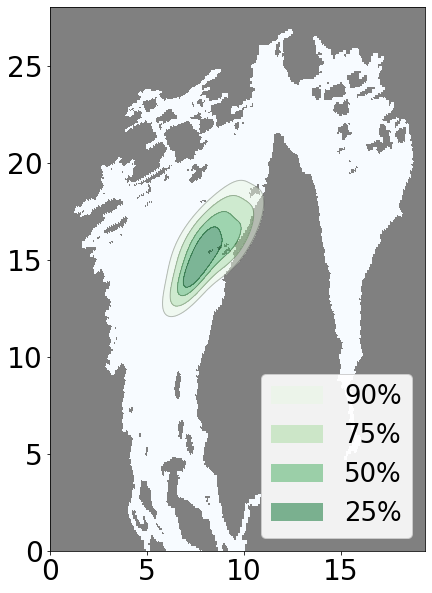

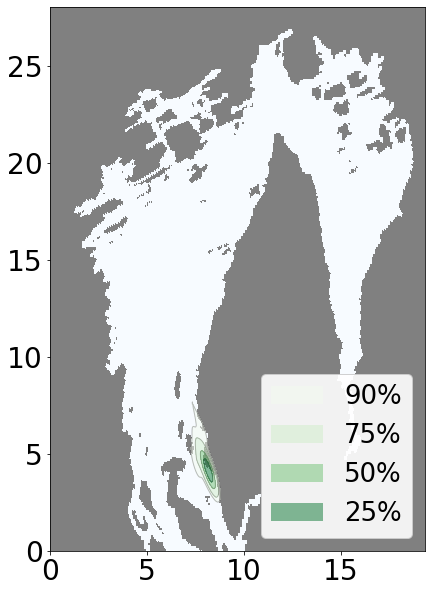

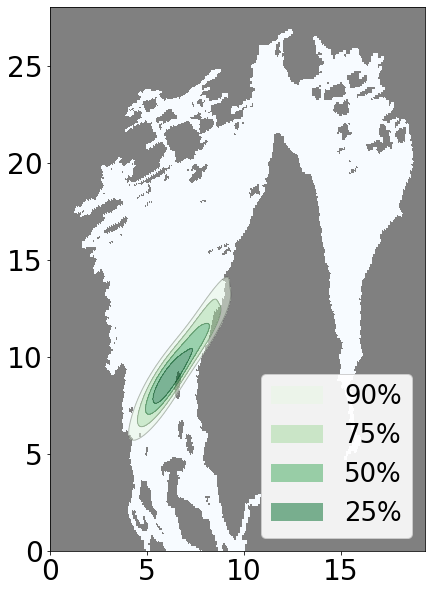

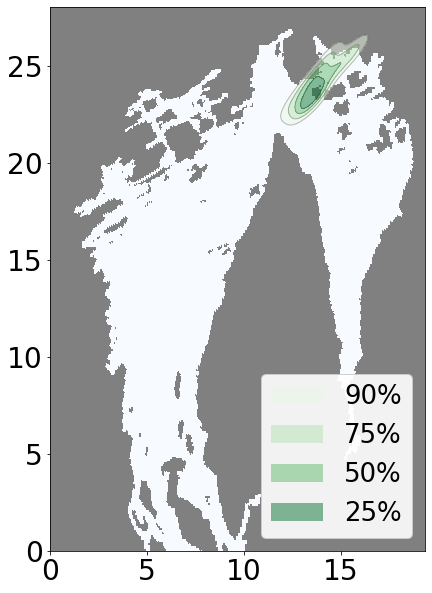

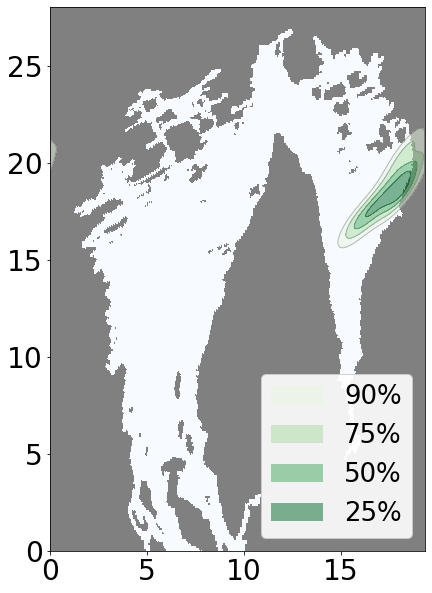

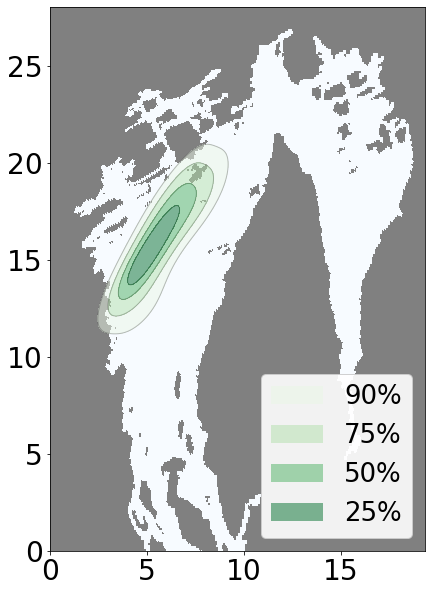

In [13]:
numDrifters = len(trajectories[0].obs_df.iloc[0].drifter_positions)
for d in range(numDrifters):
    plot_cp_kde(trajectories, d)